In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import sklearn
from tqdm import tqdm
import skimage
from skimage import transform
from numpy import load
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, Concatenate, Input
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir "/content/Data"
!unzip "/content/drive/Shareddrives/Multiverse Clones/WorkingSelfMade/FinalBrightnessAndSimpleVariedData.zip" -d "/content/Data"

In [4]:
def get_data(folder,countMax):
    x = []
    y = []
    for folderName in os.listdir(folder):
        label = folderName
        print(label)
        for image_filename in tqdm(os.listdir(folder + "/" + folderName)[0:countMax]):
            img = cv2.imread(folder +'/' + folderName + '/' + image_filename)
            if img is not None:
                x.append(img)
                y.append(label)
    x = np.array(x)
    y = np.array(y)
    return x, y

def saveNpy(name,array):
  np.save(name,array)

def loadNpy(location):
  return load(location)
  # load('/content/drive/Shareddrives/Multiverse Clones/SelfMadeData/NpyFiles/data_train_attribute.npy')

def cropImage(img,noOfIter):
  for i in range(0,noOfIter):
    ybottom = 0
    ytop = img.shape[1]
    for i in range(0,len(img)):
      for j in range(0,len(img[i])):
        if(img[i][j]!=0):
          ytop = min(ytop,i)
          ybottom = max(ybottom,i)
          break

    xleft = img.shape[1]
    xright = 0
    for j in range(0,len(img[0])):
      for i in range(0,len(img)):
        if(img[i][j]!=0):
          xleft = min(xleft,j)
          xright = max(xright,j)
          break
    img = img[ytop:ybottom,xleft:xright]
  return img

def showGrayImage(img):
  plt.imshow(img,cmap = 'gray')
  plt.show()

def resizeImage(img,imageSize):
  return skimage.transform.resize(img, (imageSize, imageSize))

def oneHotEncoding(a,size):
  return tf.one_hot(a.reshape(-1), size)

def getOutline(img):
  outline_kernel = np.array([[-1, -1, -1],
                           [-1, 8, -1],
                           [-1, -1, -1]])
  return cv2.filter2D(img, -1, outline_kernel)

def convertImagesToOutline(a):
  b = []
  for i in a:
    tmp = getOutline(i)
    b.append(tmp)
  return np.array(b)

def cropAndResize(data,noOfIter):
  corrData = []
  for img in tqdm(dat):
    corrData.append(resizeImage(cropImage(img,noOfIter),50))
  return np.array(corrData)

def take_photo(filename='photo.jpg', quality=1):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

def convertToCanny(data,LowIntensity,HighIntensity):
  tmp = []
  for i in tqdm(data):
    tmp.append(cv2.Canny(i,LowIntensity,HighIntensity))
  return np.array(tmp)

def printData(data,oneLine):
  count = 0
  for i in range(0,len(data)):
    count+=1
    print(data[i],end = ' ')
    if(count>oneLine):
      count=0
      print()

def getClassMap(data):
  uniqueElements = list(set(data))
  classNo = 0
  classMap = {}
  for i in uniqueElements:
    classMap[i] = classNo
    classNo += 1
  return classMap

def replaceWithClass(data,classMap):
  tmp = []
  for i in range(0,len(data)):
    tmp.append(classMap[data[i]])
  return np.array(tmp)

def getCorrectClass(tmpClass,classMap):
  for key, value in classMap.items():
         if value == tmpClass:
             return key

def getIndex(data):
  for i in range(0,len(data)):
    if(data[i]!=0):
      return i

def resizeData(data,imageSize):
  tmp = []
  for img in tqdm(data):
    tmp.append(skimage.transform.resize(img, (imageSize, imageSize)))
  return np.array(tmp)


In [ ]:
# img_float32 = np.float32(x_train[0])
# gryimg = cv2.cvtColor(img_float32, cv2.COLOR_BGR2GRAY)

In [ ]:
x, y = get_data("/content/Data/data/",1350)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 2)
del x
del y

In [62]:
rnd_idx = random.randint(0,len(x_train)-1)

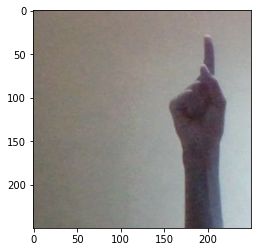

1


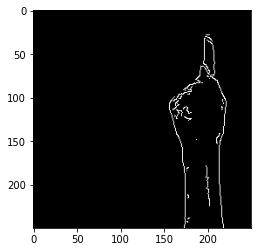

In [63]:
img = x_train[rnd_idx]
plt.imshow(img)
plt.show()
print(y_train[rnd_idx])
img = cv2.Canny(img, 50, 100)
plt.imshow(img,cmap='gray')
plt.show()

In [ ]:
x_train = convertToCanny(x_train,50,100)
x_test = convertToCanny(x_test,50,100)

5


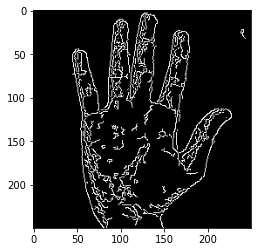

In [81]:
rnd_idx = random.randint(0,len(x_train)-1)
img = x_train[rnd_idx]

print(y_train[rnd_idx])
plt.imshow(img,cmap = 'gray')
plt.show()

In [82]:
x_train = resizeData(x_train,100)
x_test = resizeData(x_test,100)

100%|██████████| 3645/3645 [00:14<00:00, 243.60it/s]


In [ ]:
# saveNpy('x_train.npy',x_train)
# saveNpy('x_test.npy',x_test)
# saveNpy('y_train.npy',y_train)
# saveNpy('y_test.npy',y_test)

In [ ]:
# x_train = load('/content/drive/Shareddrives/Multiverse Clones/WorkingModelData/Npy of 200pg/x_train.npy')
# x_test = load('/content/drive/Shareddrives/Multiverse Clones/WorkingModelData/Npy of 200pg/x_test.npy')
# y_train = load('/content/drive/Shareddrives/Multiverse Clones/WorkingModelData/Npy of 200pg/y_train.npy')
# y_test = load('/content/drive/Shareddrives/Multiverse Clones/WorkingModelData/Npy of 200pg/y_test.npy')

In [ ]:
printData(y_train,50)

In [84]:
# classMap = getClassMap(y_train)
classMap = {'0':0, '1':1, '2':2, '3':3, '4':4, '5':5, 'EQUALS':6, 'NONE':7, 'SUM':8}

In [85]:
y_train = replaceWithClass(y_train,classMap)
y_test = replaceWithClass(y_test,classMap)

In [ ]:
printData(y_train,50)

In [87]:
size = 9
y_train = oneHotEncoding(y_train,size)
y_test = oneHotEncoding(y_test,size)

0


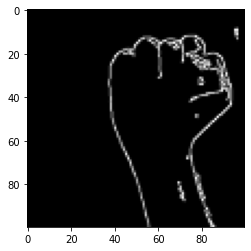

In [98]:
rnd_idx = random.randint(0,len(x_train)-1)
img = x_train[rnd_idx]
label = y_train[rnd_idx]
label = getCorrectClass(getIndex(label),classMap)

print(label)
showGrayImage(img)

In [99]:
# Set input shape
sample_shape = x_train[0].shape
img_width, img_height = sample_shape[0], sample_shape[1]
input_shape = (img_width, img_height, 1)

# Reshape data 
x_train_model = x_train.reshape(len(x_train), input_shape[0], input_shape[1], input_shape[2])
x_test_model  = x_test.reshape(len(x_test), input_shape[0], input_shape[1], input_shape[2])

In [100]:
print(input_shape)
print(x_train.shape)
print(x_train_model.shape)

(100, 100, 1)
(8505, 100, 100)
(8505, 100, 100, 1)


In [ ]:
model = Sequential(name="HandSignToSpeech")

model.add(Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(64, activation='relu'))
model.add(Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

In [132]:
model.fit(x=x_train_model, y=y_train, epochs=10)

Epoch 1/10
266/266 [==============================] - 12s 44ms/step - loss: 1.0754 - accuracy: 0.6306
Epoch 2/10
266/266 [==============================] - 12s 44ms/step - loss: 0.3621 - accuracy: 0.8821
Epoch 3/10
266/266 [==============================] - 12s 44ms/step - loss: 0.2009 - accuracy: 0.9342
Epoch 4/10
266/266 [==============================] - 12s 44ms/step - loss: 0.1394 - accuracy: 0.9577
Epoch 5/10
266/266 [==============================] - 12s 44ms/step - loss: 0.0972 - accuracy: 0.9681
Epoch 6/10
266/266 [==============================] - 12s 44ms/step - loss: 0.0814 - accuracy: 0.9759
Epoch 7/10
266/266 [==============================] - 12s 44ms/step - loss: 0.0717 - accuracy: 0.9792
Epoch 8/10
266/266 [==============================] - 12s 44ms/step - loss: 0.0627 - accuracy: 0.9817
Epoch 9/10
266/266 [==============================] - 12s 44ms/step - loss: 0.0575 - accuracy: 0.9837
Epoch 10/10
266/266 [==============================] - 12s 44ms/step - loss: 0.051

In [133]:
model.evaluate(x=x_test_model, y=y_test)

114/114 [==============================] - 2s 20ms/step - loss: 0.1707 - accuracy: 0.9572


[0.17072594165802002, 0.9572016596794128]

<IPython.core.display.Javascript object>

Saved to photo.jpg


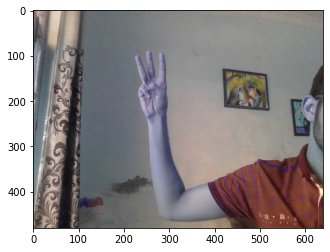

In [104]:
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  img = cv2.imread('/content/photo.jpg')
  plt.imshow(img)
  plt.show()
except Exception as err:
  print(str(err))

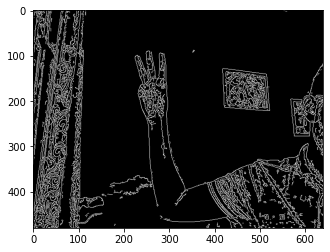

In [134]:
img = cv2.imread('/content/photo.jpg')
img = cv2.Canny(img, 50, 100)
plt.imshow(img, cmap='gray')
plt.show()

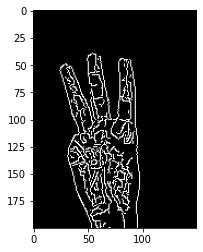

In [135]:
img = img[50:250,200:350]
plt.imshow(img,cmap='gray')
plt.show()
# img = cv2.flip(img, 1)
# plt.imshow(img,cmap = 'gray')

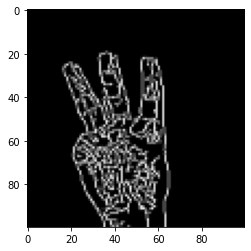

In [136]:
imageSize = 100
img = skimage.transform.resize(img, (imageSize, imageSize))
plt.imshow(img,cmap='gray')
plt.show()

In [137]:
pred = model.predict(img.reshape(1, img.shape[0], img.shape[1], 1))
pred_cls = np.argmax(pred)
print(pred)
print(getCorrectClass(pred_cls,classMap))
print(classMap)

[[2.7196648e-10 2.2834830e-18 7.8795651e-11 9.6861666e-01 3.1383269e-02
  1.6162570e-11 2.2318376e-14 5.1635099e-17 6.3649417e-13]]
3
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, 'EQUALS': 6, 'NONE': 7, 'SUM': 8}


In [138]:
model.save("UltimateUltimateHeaven.h5")